# Clusterizacao - Case ImdbMovies

# IMDb TOP 250 Movies
![An image](https://static.amazon.jobs/teams/53/images/IMDb_Header_Page.jpg?1501027252)

**Este projeto consiste em treinar um sistema de recomendação de filmes utilizando as informações referentes aos top 250 filmes melhor avaliados pelo público na plataforma IMDb.**
*   A extração dos dados será feita por técnicas de web scraping (crawler).
*   O objetivo principal será agrupar os 250 filmes em "n" clusters classificados a partir das suas sinopses, aplicando técnicas de processamento de texto e algoritmos de clusterização.
*   Ao final, teremos um sistemas de recomendação baseado na similaridade das sinopses, e não apenas dos generos.

**Exemplo de aplicação prática: usuários receberão recomendações de filmes que estejam no mesmo cluster de sinopses de outros filmes que ele já tenha curtido.**

# Import das bibliotecas

In [93]:
#No Google Colab será necessário executar as instalações abaixo a cada nova sessão.
#No Jupyter Notebook, Jupyter Lab ou VSCode (localhost) basta instalar uma única vez.
# !pip uninstall pycaret
# !pip uninstall pandas
# !pip install pycaret
# !pip install wordcloud
# !pip install nltk


In [94]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from pycaret.clustering import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## DataFrame

In [95]:
# from google.colab import drive
# drive.mount('/content/drive')

#EDA - Exploratory Data Analysis

In [96]:
df = pd.read_csv(f'./all_movies.csv', sep = ';')

print(df.shape)
df.head()

(250, 6)


title_pt                     title_en  year  rating     genre                                            sinopse
0                          Barbie                       Barbie  2023     7.4  Aventura  Viver na Terra da Barbie é ser um ser perfeito...
1           Um Sonho de Liberdade  1. The Shawshank Redemption  1994     9.3     Drama  Dois homens presos se reúnem ao longo de vário...
2               O Poderoso Chefão             2. The Godfather  1972     9.2  Policial  O patriarca idoso de uma dinastia do crime org...
3  Batman: O Cavaleiro das Trevas           3. The Dark Knight  2008     9.0      Ação  Quando a ameaça conhecida como O Coringa surge...
4            O Poderoso Chefão II     4. The Godfather Part II  1974     9.0  Policial  Em 1950, Michael Corleone, agora à frente da f...

In [97]:
# Adjusting variable types
df['year'] = df['year'].astype('int64')
df['rating'] = df['rating'].astype('float64')

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   title_pt  250 non-null    object 
 1   title_en  250 non-null    object 
 2   year      250 non-null    int64  
 3   rating    250 non-null    float64
 4   genre     250 non-null    object 
 5   sinopse   250 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 11.8+ KB


In [99]:
df.describe()

year      rating
count   250.000000  250.000000
mean   1986.684000    8.302800
std      25.508171    0.239545
min    1921.000000    7.400000
25%    1966.000000    8.100000
50%    1994.000000    8.200000
75%    2007.000000    8.400000
max    2023.000000    9.300000

## Plots

In [100]:
df.genre.value_counts('d')

genre
Drama         0.276
Ação          0.180
Policial      0.140
Animação      0.096
Biografia     0.092
Comédia       0.092
Aventura      0.084
Terror        0.016
Mistério      0.016
Faroeste      0.004
Filme noir    0.004
Name: proportion, dtype: float64

In [101]:
fig = px.bar(df.genre.value_counts('d')*100,
             text_auto=True,
             title = '% de Filmes por Gênero',
             labels={'index':'Gênero',
                     'value':'% de Filmes'})
fig.show()

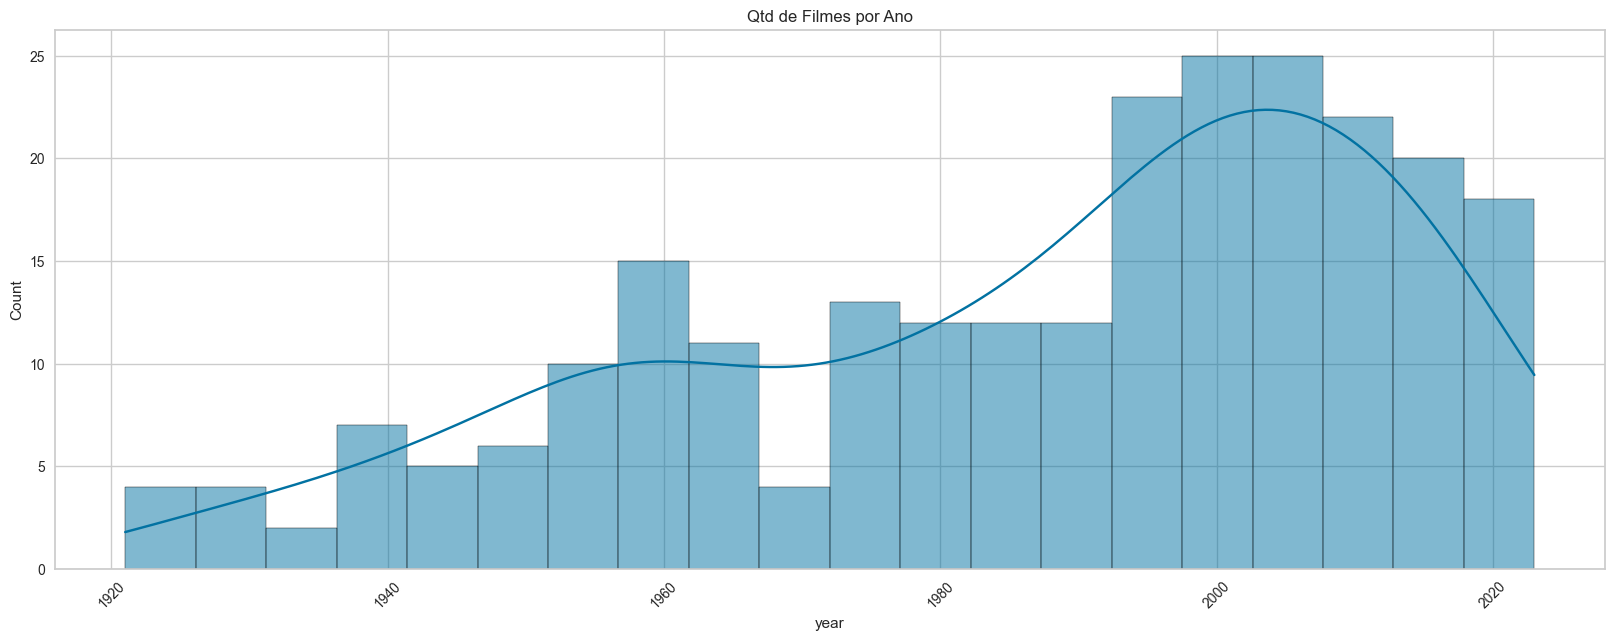

In [102]:
plt.figure(figsize = (20,7))
sns.histplot( df,
              x = 'year',
              kde = True, bins = 20).set_title('Qtd de Filmes por Ano')
plt.xticks(rotation=45)
plt.show()

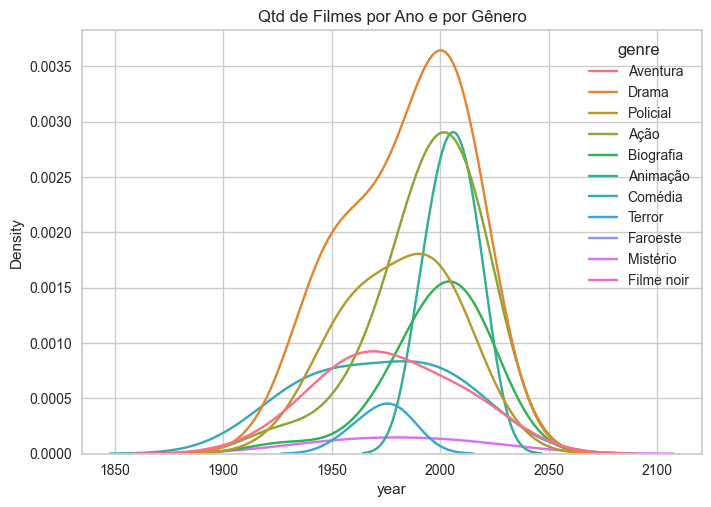

In [103]:
sns.kdeplot( df, x = 'year', hue = 'genre', bw_adjust = 1.5, warn_singular = False).set_title('Qtd de Filmes por Ano e por Gênero')
plt.show()

# Pré-processamento de texto

In [104]:
#convert sinopses to lowercase
df_processed = df.copy()
df_processed['sinopse'] = df_processed['sinopse'].str.lower()
df_processed['sinopse'].head()

0    viver na terra da barbie é ser um ser perfeito...
1    dois homens presos se reúnem ao longo de vário...
2    o patriarca idoso de uma dinastia do crime org...
3    quando a ameaça conhecida como o coringa surge...
4    em 1950, michael corleone, agora à frente da f...
Name: sinopse, dtype: object

In [105]:
def qty_words(text):
    words= text.split()
    word_count = len(words)
    return word_count

In [106]:
### Feature Engineering
df_processed['word_count'] = df_processed['sinopse'].apply(qty_words).astype('int64')
df_processed.head()

title_pt                     title_en  year  rating     genre                                            sinopse  word_count
0                          Barbie                       Barbie  2023     7.4  Aventura  viver na terra da barbie é ser um ser perfeito...          29
1           Um Sonho de Liberdade  1. The Shawshank Redemption  1994     9.3     Drama  dois homens presos se reúnem ao longo de vário...          21
2               O Poderoso Chefão             2. The Godfather  1972     9.2  Policial  o patriarca idoso de uma dinastia do crime org...          20
3  Batman: O Cavaleiro das Trevas           3. The Dark Knight  2008     9.0      Ação  quando a ameaça conhecida como o coringa surge...          33
4            O Poderoso Chefão II     4. The Godfather Part II  1974     9.0  Policial  em 1950, michael corleone, agora à frente da f...          41

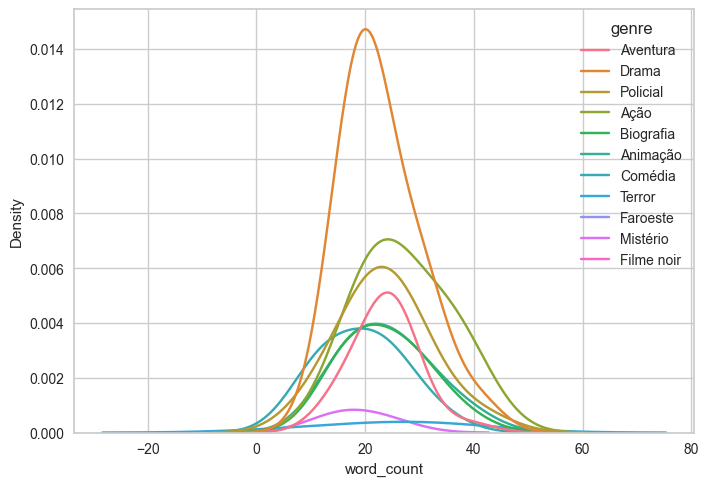

In [107]:
sns.kdeplot( df_processed, x = 'word_count', hue = 'genre', bw_adjust = 1.5, warn_singular = False)
plt.show()

## Nuvem de palavras

### Antes de remover as stopwords

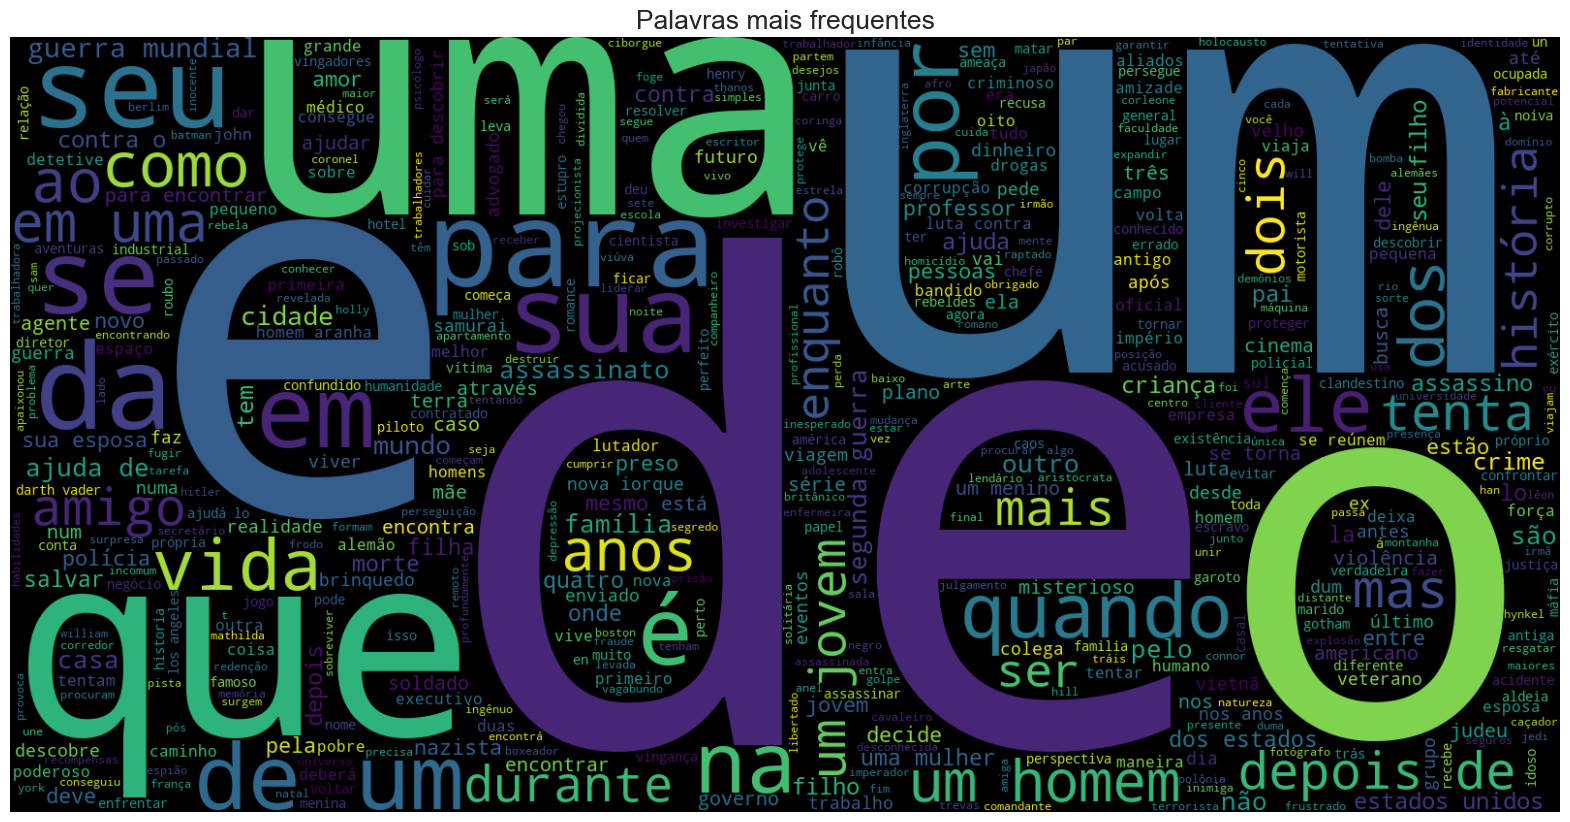

In [108]:
text = ' '.join([phrase for phrase in df_processed['sinopse']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais frequentes', fontsize = 19)
plt.show()

### Após remoção das stopwords

In [109]:
import nltk
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('portuguese')
print(stopwords)

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'éramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estou', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'formos', 'fosse', 'fossem', 'fôssemos', 'fui', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'haver', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvésse

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\M4005001\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


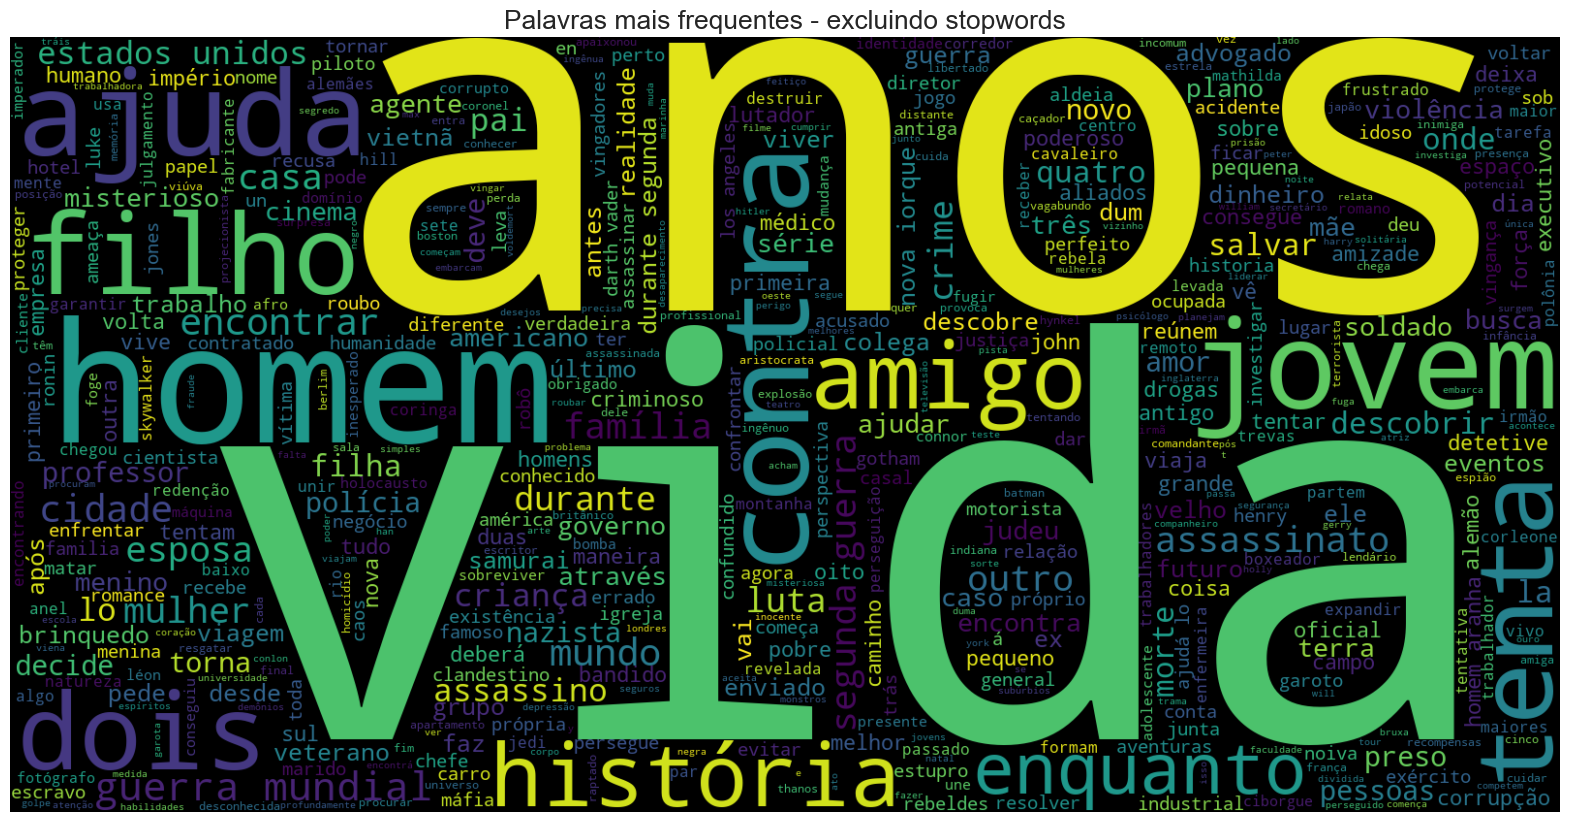

In [110]:
df_processed['sinopse_no_stopwords'] = df_processed['sinopse'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
text = ' '.join([phrase for phrase in df_processed['sinopse_no_stopwords']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais frequentes - excluindo stopwords', fontsize = 19)
plt.show()

## Aplicando TF-IDF
Term Frequency-Inverse Document Frequency

O TF-IDF define a importância de um termo levando em consideração a importância desse termo em um único documento e dimensionando-o por sua importância em todos os documentos.

In [111]:
# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(df_processed['sinopse_no_stopwords'])

In [112]:
print(X.shape)
X.toarray()

(250, 82)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.70710678],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# AutoML | PyCaret - Clustering

# Model 1

## Setup

In [113]:
s = setup(data = X.toarray(),
          session_id = 123)

## Create Model

In [114]:
mdl_kmeans = create_model('kmeans')

In [115]:
mdl_dbscan = create_model('dbscan')

## Assign Model

In [116]:
df_kmeans = assign_model(mdl_kmeans)
display(df_kmeans.Cluster.value_counts())
df_kmeans

Cluster
Cluster 2    219
Cluster 1     19
Cluster 0      6
Cluster 3      6
Name: count, dtype: int64

feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  feature_7  feature_8  feature_9  feature_10  feature_11  feature_12  feature_13  feature_14  feature_15  feature_16  feature_17  feature_18  feature_19  feature_20  feature_21  feature_22  feature_23  feature_24  feature_25  feature_26  feature_27  feature_28  feature_29  feature_30  feature_31  feature_32  feature_33  feature_34  feature_35  feature_36  feature_37  feature_38  feature_39  feature_40  feature_41  feature_42  feature_43  feature_44  feature_45  feature_46  feature_47  feature_48  feature_49  feature_50  feature_51  feature_52  feature_53  feature_54  feature_55  feature_56  feature_57  feature_58  feature_59  feature_60  feature_61  feature_62  feature_63  feature_64  feature_65  feature_66  feature_67  feature_68  feature_69  feature_70  feature_71  feature_72  feature_73  feature_74  feature_75  feature_76  feature_77  feature_78  feature_79  feature_80  feature_81  feature_82    Cluster
0          0.0        0.0        0.0        0.0        0.0        0.0   0.000000        0.0        0.0         0.0         0.0    0.000000         0.0         0.0         0.0         0.0         0.0         0.0    0.000000    0.000000         0.0         0.0         0.0    0.000000         0.0     0.00000         0.0    0.000000         0.0         0.0         0.0    0.000000    0.000000         0.0         0.0    0.000000         0.0         0.0    0.000000         0.0         0.0         0.0         0.0    0.000000         0.0    0.000000         0.0         0.0    0.000000    0.000000         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0    0.000000         0.0         0.0         0.0         0.0    0.000000         0.0         0.0         0.0         0.0         0.0         0.0    0.000000    0.707107         0.0         0.0         0.0    0.000000         0.0         0.0         0.0         0.0    0.707107  Cluster 2
1          0.0        0.0        0.0        0.0        0.0        0.0   0.499298        0.0        0.0         0.0         0.0    0.674508         0.0         0.0         0.0         0.0         0.0         0.0    0.000000    0.000000         0.0         0.0         0.0    0.000000         0.0     0.54382         0.0    0.000000         0.0         0.0         0.0    0.000000    0.000000         0.0         0.0    0.000000         0.0         0.0    0.000000         0.0         0.0         0.0         0.0    0.000000         0.0    0.000000         0.0         0.0    0.000000    0.000000         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0    0.000000         0.0         0.0         0.0         0.0    0.000000         0.0         0.0         0.0         0.0         0.0         0.0    0.000000    0.000000         0.0         0.0         0.0    0.000000         0.0         0.0         0.0         0.0    0.000000  Cluster 2
2          0.0        0.0        0.0        0.0        0.0        0.0   0.000000        0.0        0.0         0.0         0.0    0.000000         0.0         0.0         0.0         0.0         0.0         0.0    0.737751    0.000000         0.0         0.0         0.0    0.000000         0.0     0.00000         0.0    0.000000         0.0         0.0         0.0    0.000000    0.000000         0.0         0.0    0.000000         0.0         0.0    0.675072         0.0         0.0         0.0         0.0    0.000000         0.0    0.000000         0.0         0.0    0.000000    0.000000         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0    0.000000         0.0         0.0         0.0         0.0    0.000000         0.0         0.0         0.0         0.0         0.0         0.0    0.000000    0.000000         0.0         0.0         0.0    0.000000         0.0         0.0         0.0         0.0    0.000000  Cluster 2
3          0.0        0.0        0.0        0

In [117]:
df_db = assign_model(mdl_dbscan)
df_db.Cluster.value_counts()

Cluster
Cluster -1    241
Cluster 0       9
Name: count, dtype: int64

## Analyze Models

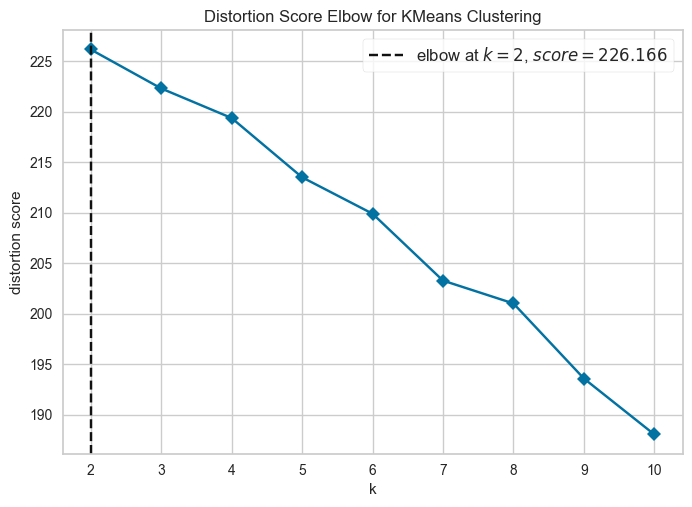

In [118]:
plot_model(mdl_kmeans, plot = 'elbow')

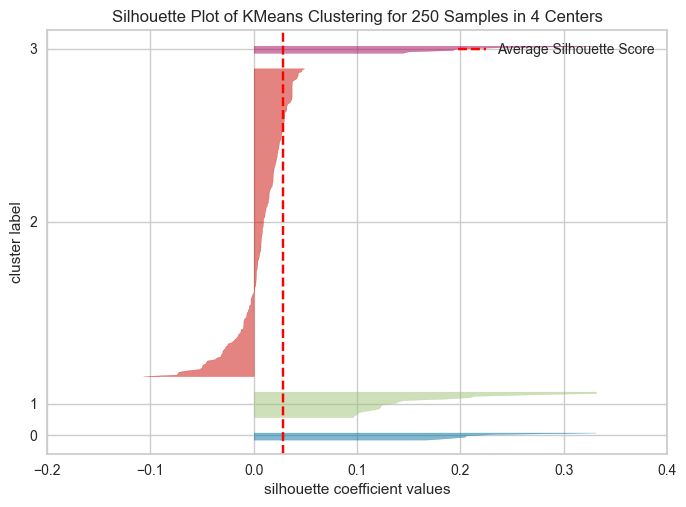

In [119]:
plot_model(mdl_kmeans, plot = 'silhouette')

In [120]:
plot_model(mdl_kmeans, plot = 'distribution')

In [121]:
plot_model(mdl_kmeans, plot = 'cluster')

In [122]:
plot_model(mdl_kmeans, plot = 'tsne')

In [123]:
evaluate_model(mdl_kmeans)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## Filmes por cluster

In [124]:
df_processed['cluster'] = df_kmeans['Cluster']
df_processed

title_pt                     title_en  year  rating     genre                                            sinopse  word_count                               sinopse_no_stopwords    cluster
0                            Barbie                       Barbie  2023     7.4  Aventura  viver na terra da barbie é ser um ser perfeito...          29  viver terra barbie perfeito lugar perfeito. me...  Cluster 2
1             Um Sonho de Liberdade  1. The Shawshank Redemption  1994     9.3     Drama  dois homens presos se reúnem ao longo de vário...          21  dois homens presos reúnem longo vários anos, e...  Cluster 2
2                 O Poderoso Chefão             2. The Godfather  1972     9.2  Policial  o patriarca idoso de uma dinastia do crime org...          20  patriarca idoso dinastia crime organizado tran...  Cluster 2
3    Batman: O Cavaleiro das Trevas           3. The Dark Knight  2008     9.0      Ação  quando a ameaça conhecida como o coringa surge...          33  ameaça conhecida coringa surge passado, causa ...  Cluster 2
4              O Poderoso Chefão II     4. The Godfather Part II  1974     9.0  Policial  em 1950, michael corleone, agora à frente da f...          41  1950, michael corleone, agora frente família, ...  Cluster 2
..                              ...                          ...   ...     ...       ...                                                ...         ...                                                ...        ...
245              Histórias Cruzadas                246. The Help  2011     8.1     Drama  uma aspirante a escritora durante o movimento ...          32  aspirante escritora durante movimento direitos...  Cluster 2
246      Quando Duas Mulheres Pecam                 247. Persona  1966     8.1     Drama  uma enfermeira é encarregada de uma atriz sile...          17  enfermeira encarregada atriz silenciosa descob...  Cluster 2
247                 A Vida de Brian           248. Life of Brian  1979     8.0   Comédia  nascido no natal original no estábulo ao lado ...          20  nascido natal original estábulo lado jesus, br...  Cluster 2
248                         Aladdin                 249. Aladdin  1992     8.0  Animação  um menino de rua bondoso e um vizir competem p...          23  menino rua bondoso vizir competem lâmpada mági...  Cluster 2
249                   As Diabólicas              250. Diabolique  1955     8.1  Policial  a esposa e a amante de um diretor de escola de...          22  esposa amante diretor escola detestável planej...  Cluster 2

[250 rows x 9 columns]

## % de Gêneros por Cluster

In [125]:
fig = px.bar(df_processed.cluster.value_counts(),
             text_auto = True,
             title = 'Qtd de Filmes por Cluster',
             labels = {'index': 'Cluster #',
                       'value':'Qtd. de Filmes'})
fig.show()

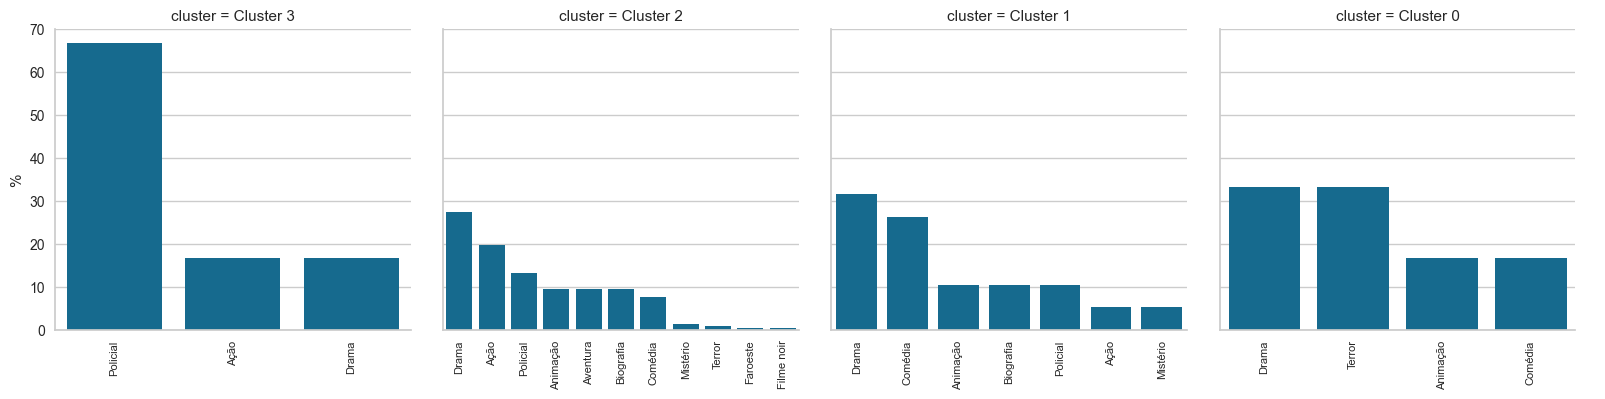

In [126]:
df_plot = df_processed.groupby(['cluster', 'genre'])['title_pt'].count()
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'title_pt':'count'}, inplace = True)
df_plot['%'] = 100 * df_plot['count'] / df_plot.groupby('cluster')['count'].transform('sum')
df_plot = df_plot.sort_values(['cluster', '%'], ascending = False).groupby('cluster').head(11)

fig = sns.catplot(
    data=df_plot, x="genre", y = "%", col="cluster",
    kind="bar", height=4, aspect=1, sharex = False);
fig.set_xlabels('');
fig.set_xticklabels(rotation=90, size = 8);

## Ano de Lançamento por Cluster

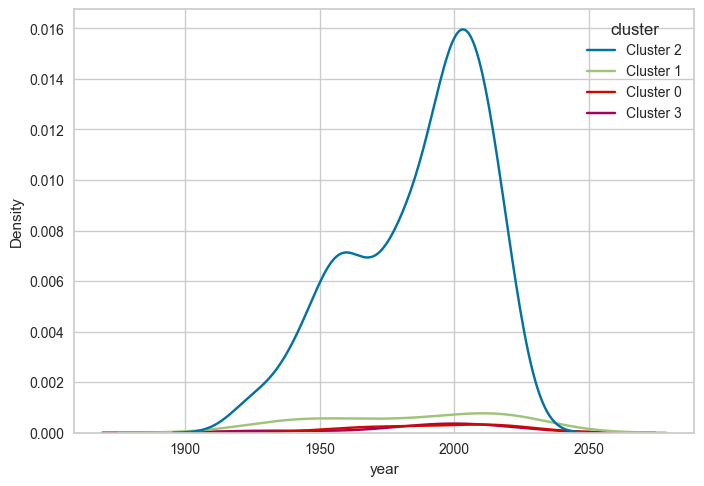

In [127]:
sns.kdeplot(df_processed, x = 'year', hue = 'cluster');

## Radar | Gêneros por Cluster

In [128]:
df_pivot = df_plot.copy()
df_pivot = df_pivot.pivot(index = 'cluster', columns = 'genre', values = '%')
df_pivot.fillna(0, inplace = True)
df_pivot = df_pivot.T.reset_index()
df_pivot.index.name = None
df_pivot

cluster       genre  Cluster 0  Cluster 1  Cluster 2  Cluster 3
0          Animação  16.666667  10.526316   9.589041   0.000000
1          Aventura   0.000000   0.000000   9.589041   0.000000
2              Ação   0.000000   5.263158  19.634703  16.666667
3         Biografia   0.000000  10.526316   9.589041   0.000000
4           Comédia  16.666667  26.315789   7.762557   0.000000
5             Drama  33.333333  31.578947  27.397260  16.666667
6          Faroeste   0.000000   0.000000   0.456621   0.000000
7        Filme noir   0.000000   0.000000   0.456621   0.000000
8          Mistério   0.000000   5.263158   1.369863   0.000000
9          Policial   0.000000  10.526316  13.242009  66.666667
10           Terror  33.333333   0.000000   0.913242   0.000000

In [129]:
df_polar = df_pivot.melt(id_vars=['genre'])
df_polar.head()

genre    cluster      value
0   Animação  Cluster 0  16.666667
1   Aventura  Cluster 0   0.000000
2       Ação  Cluster 0   0.000000
3  Biografia  Cluster 0   0.000000
4    Comédia  Cluster 0  16.666667

In [130]:
fig = px.line_polar(df_polar, r='value', theta='genre', color = 'cluster', line_close=True)
fig.show();

## Nuvem de Palavras por Cluster

## Considerações Finais
* **Exercício: Reescrever as análises / conclusões devido a atualização da base**

Cluster 2


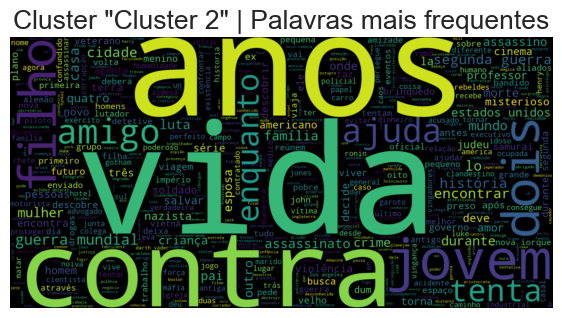

Cluster 1


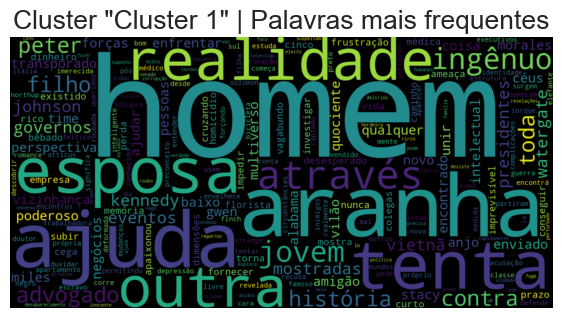

Cluster 0


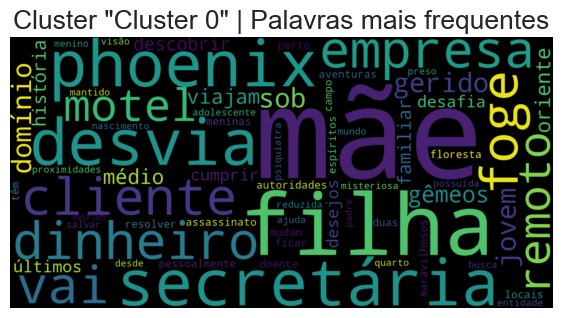

Cluster 3


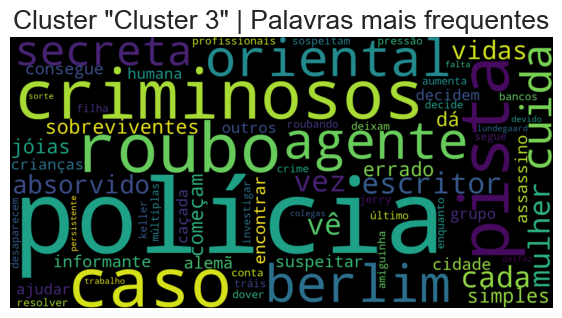

In [131]:
def word_cloud_cluster(cluster:int):
  text = ' '.join([phrase for phrase in df_processed.loc[df_processed.cluster == cluster]['sinopse_no_stopwords']])
  plt.figure(figsize=(7,5), facecolor='None')
  wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Cluster "{cluster}" | Palavras mais frequentes', fontsize = 19)
  plt.show()
  return

list_clusters = df_processed.cluster.unique().tolist()
for c in list_clusters:
  print(c)
  word_cloud_cluster(c)

## Conclusões | Model 1

In [132]:
#Escreva aqui as suas análises / conclusões

# Model 2

## Adicionando demais features do df all_movies ao X

In [133]:
pd.DataFrame(X.toarray()).shape

(250, 82)

In [134]:
df_processed.shape

(250, 9)

In [135]:
df_all = pd.concat([
                    df_processed.drop('cluster', axis = 1),
                    pd.DataFrame(X.toarray())
                   ]
                   , axis = 1
                   )
df_all.head()

title_pt                     title_en  year  rating     genre                                            sinopse  word_count                               sinopse_no_stopwords    0    1    2    3    4    5         6    7    8    9   10        11   12   13   14   15   16   17        18   19   20   21   22        23   24       25   26   27   28   29   30   31   32   33   34        35   36   37        38   39   40   41   42        43   44        45   46   47   48        49   50   51   52   53   54   55   56   57   58        59   60   61   62   63        64   65   66   67   68   69   70        71        72   73   74   75   76   77   78   79   80        81
0                          Barbie                       Barbie  2023     7.4  Aventura  viver na terra da barbie é ser um ser perfeito...          29  viver terra barbie perfeito lugar perfeito. me...  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.707107  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.707107
1           Um Sonho de Liberdade  1. The Shawshank Redemption  1994     9.3     Drama  dois homens presos se reúnem ao longo de vário...          21  dois homens presos reúnem longo vários anos, e...  0.0  0.0  0.0  0.0  0.0  0.0  0.499298  0.0  0.0  0.0  0.0  0.674508  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.54382  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000
2               O Poderoso Chefão             2. The Godfather  1972     9.2  Policial  o patriarca idoso de uma dinastia do crime org...          20  patriarca idoso dinastia crime organizado tran...  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.737751  0.0  0.0  0.0  0.0  0.000000  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.675072  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000
3  Batman: O Cavaleiro das Trevas           3. The Dark Knight  2008     9.0      Ação  quando a ameaça conhecida como o coringa surge...          33  ameaça conhecida coringa surge passado, causa ...  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.707107  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.707107  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000
4            O Poderoso Chefão II     4. The Godfather Part II  1974     9.0  Policial  em 1950, michael corleone, agora à frente da f...          41  1950, michael corleone, agora frente família, ...  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.384293  0.0  0.0  0.0  0.0  0.000000  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.384293  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.358751  0.0  0.420294  0.0  0.0  0.0  0.384293  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.374939  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0 

## Setup

In [136]:
s = setup(data = df_all,
          session_id = 123)

## Create Model

In [137]:
mdl_kmeans_all = create_model('kmeans')

## Assign Model

In [138]:
df_kmeans_all = assign_model(mdl_kmeans_all)
display(df_kmeans_all.Cluster.value_counts())
df_kmeans_all

Cluster
Cluster 3    79
Cluster 1    66
Cluster 0    57
Cluster 2    48
Name: count, dtype: int64

title_pt                     title_en  year  rating     genre                                            sinopse  word_count                               sinopse_no_stopwords    0    1    2    3    4    5         6    7    8    9   10        11   12   13   14   15   16   17        18        19   20   21   22        23   24       25   26        27   28   29   30        31        32   33   34        35   36   37        38   39   40   41   42        43   44        45   46   47        48        49   50   51   52   53   54   55   56   57   58        59   60   61   62   63        64   65   66   67   68   69   70        71        72   73   74   75        76   77   78   79   80        81    Cluster
0                            Barbie                       Barbie  2023     7.4  Aventura  viver na terra da barbie é ser um ser perfeito...          29  viver terra barbie perfeito lugar perfeito. me...  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.000000  0.0  0.00000  0.0  0.000000  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.707107  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.707107  Cluster 2
1             Um Sonho de Liberdade  1. The Shawshank Redemption  1994     9.3     Drama  dois homens presos se reúnem ao longo de vário...          21  dois homens presos reúnem longo vários anos, e...  0.0  0.0  0.0  0.0  0.0  0.0  0.499298  0.0  0.0  0.0  0.0  0.674508  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.000000  0.0  0.54382  0.0  0.000000  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  Cluster 3
2                 O Poderoso Chefão             2. The Godfather  1972     9.2  Policial  o patriarca idoso de uma dinastia do crime org...          20  patriarca idoso dinastia crime organizado tran...  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.737751  0.000000  0.0  0.0  0.0  0.000000  0.0  0.00000  0.0  0.000000  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.675072  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  Cluster 0
3    Batman: O Cavaleiro das Trevas           3. The Dark Knight  2008     9.0      Ação  quando a ameaça conhecida como o coringa surge...          33  ameaça conhecida coringa surge passado, causa ...  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.707107  0.0  0.00000  0.0  0.000000  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.707107  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  Cluster 2
4              O Poderoso Chefão II     4. The Godfather Part II  1974     9.0  Policial  em 1950, michael corleone, agora à frente da f...          41  1950, michael corleone, agora frente família, ...  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.384293  0.000000  0.0  0.0  0.0  0.000000  0.0  0.00000  0.0  0.000000  0.0  0.0 

## Analyze Model

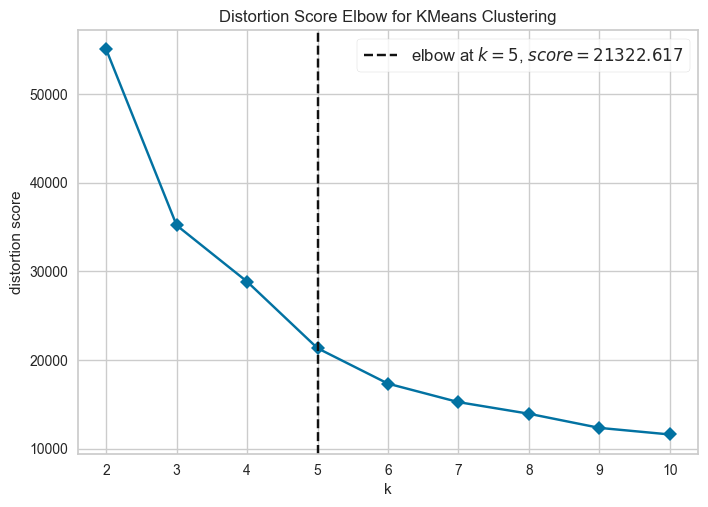

In [139]:
plot_model(mdl_kmeans_all, plot = 'elbow')

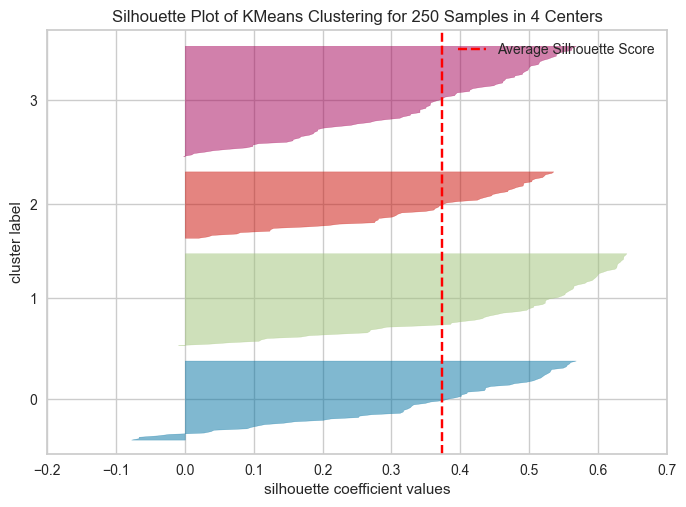

In [140]:
plot_model(mdl_kmeans_all, plot = 'silhouette')

In [141]:
plot_model(mdl_kmeans_all, plot = 'distribution')

In [142]:
plot_model(mdl_kmeans_all, plot = 'cluster')

In [143]:
plot_model(mdl_kmeans_all, plot = 'tsne')

In [144]:
evaluate_model(mdl_kmeans_all)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## Filmes por cluster

In [145]:
df_processed['cluster'] = df_kmeans_all['Cluster']
df_processed

title_pt                     title_en  year  rating     genre                                            sinopse  word_count                               sinopse_no_stopwords    cluster
0                            Barbie                       Barbie  2023     7.4  Aventura  viver na terra da barbie é ser um ser perfeito...          29  viver terra barbie perfeito lugar perfeito. me...  Cluster 2
1             Um Sonho de Liberdade  1. The Shawshank Redemption  1994     9.3     Drama  dois homens presos se reúnem ao longo de vário...          21  dois homens presos reúnem longo vários anos, e...  Cluster 3
2                 O Poderoso Chefão             2. The Godfather  1972     9.2  Policial  o patriarca idoso de uma dinastia do crime org...          20  patriarca idoso dinastia crime organizado tran...  Cluster 0
3    Batman: O Cavaleiro das Trevas           3. The Dark Knight  2008     9.0      Ação  quando a ameaça conhecida como o coringa surge...          33  ameaça conhecida coringa surge passado, causa ...  Cluster 2
4              O Poderoso Chefão II     4. The Godfather Part II  1974     9.0  Policial  em 1950, michael corleone, agora à frente da f...          41  1950, michael corleone, agora frente família, ...  Cluster 0
..                              ...                          ...   ...     ...       ...                                                ...         ...                                                ...        ...
245              Histórias Cruzadas                246. The Help  2011     8.1     Drama  uma aspirante a escritora durante o movimento ...          32  aspirante escritora durante movimento direitos...  Cluster 2
246      Quando Duas Mulheres Pecam                 247. Persona  1966     8.1     Drama  uma enfermeira é encarregada de uma atriz sile...          17  enfermeira encarregada atriz silenciosa descob...  Cluster 1
247                 A Vida de Brian           248. Life of Brian  1979     8.0   Comédia  nascido no natal original no estábulo ao lado ...          20  nascido natal original estábulo lado jesus, br...  Cluster 0
248                         Aladdin                 249. Aladdin  1992     8.0  Animação  um menino de rua bondoso e um vizir competem p...          23  menino rua bondoso vizir competem lâmpada mági...  Cluster 0
249                   As Diabólicas              250. Diabolique  1955     8.1  Policial  a esposa e a amante de um diretor de escola de...          22  esposa amante diretor escola detestável planej...  Cluster 1

[250 rows x 9 columns]

## % de Gêneros por Cluster

In [146]:
fig = px.bar(df_processed.cluster.value_counts(),
             text_auto = True,
             title = 'Qtd de Filmes por Cluster',
             labels = {'index': 'Cluster #',
                       'value':'Qtd. de Filmes'})
fig.show()

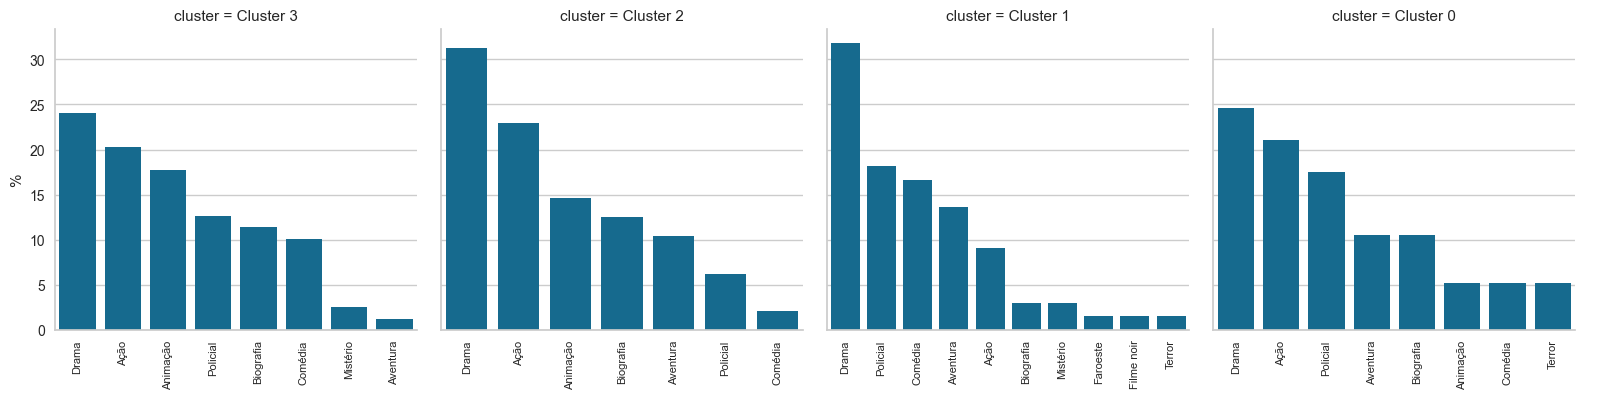

In [147]:
df_plot = df_processed.groupby(['cluster', 'genre'])['title_pt'].count()
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'title_pt':'count'}, inplace = True)
df_plot['%'] = 100 * df_plot['count'] / df_plot.groupby('cluster')['count'].transform('sum')
df_plot = df_plot.sort_values(['cluster', '%'], ascending = False).groupby('cluster').head(11)

fig = sns.catplot(
    data=df_plot, x="genre", y = "%", col="cluster",
    kind="bar", height=4, aspect=1, sharex = False);
fig.set_xlabels('');
fig.set_xticklabels(rotation=90, size = 8);

## Ano de Lançamento por Cluster

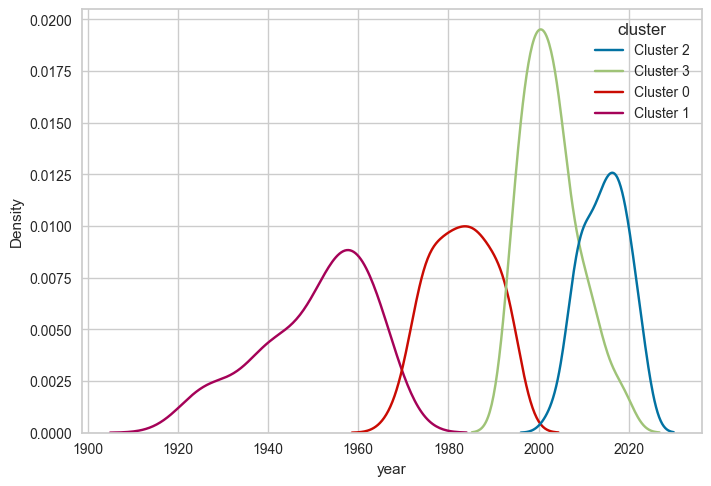

In [148]:
sns.kdeplot(df_processed, x = 'year', hue = 'cluster');

## Radar | Gêneros por Cluster

In [149]:
df_pivot = df_plot.copy()
df_pivot = df_pivot.pivot(index = 'cluster', columns = 'genre', values = '%')
df_pivot.fillna(0, inplace = True)
df_pivot = df_pivot.T.reset_index()
df_pivot.index.name = None
df_pivot

cluster       genre  Cluster 0  Cluster 1  Cluster 2  Cluster 3
0          Animação   5.263158   0.000000  14.583333  17.721519
1          Aventura  10.526316  13.636364  10.416667   1.265823
2              Ação  21.052632   9.090909  22.916667  20.253165
3         Biografia  10.526316   3.030303  12.500000  11.392405
4           Comédia   5.263158  16.666667   2.083333  10.126582
5             Drama  24.561404  31.818182  31.250000  24.050633
6          Faroeste   0.000000   1.515152   0.000000   0.000000
7        Filme noir   0.000000   1.515152   0.000000   0.000000
8          Mistério   0.000000   3.030303   0.000000   2.531646
9          Policial  17.543860  18.181818   6.250000  12.658228
10           Terror   5.263158   1.515152   0.000000   0.000000

In [150]:
df_polar = df_pivot.melt(id_vars=['genre'])
df_polar.head()

genre    cluster      value
0   Animação  Cluster 0   5.263158
1   Aventura  Cluster 0  10.526316
2       Ação  Cluster 0  21.052632
3  Biografia  Cluster 0  10.526316
4    Comédia  Cluster 0   5.263158

In [151]:
fig = px.line_polar(df_polar, r='value', theta='genre', color = 'cluster', line_close=True)
fig.show();

## Nuvem de Palavras por Cluster

## Considerações Finais
* **Exercício: Reescrever as análises / conclusões devido a atualização da base**

Cluster 2


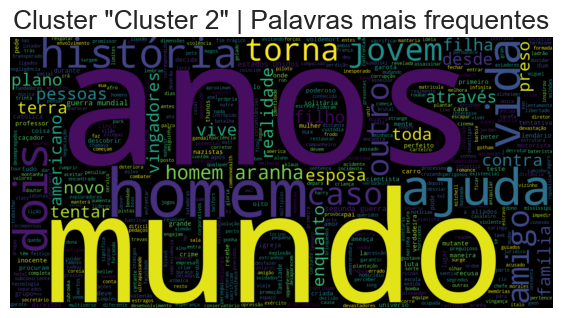

Cluster 3


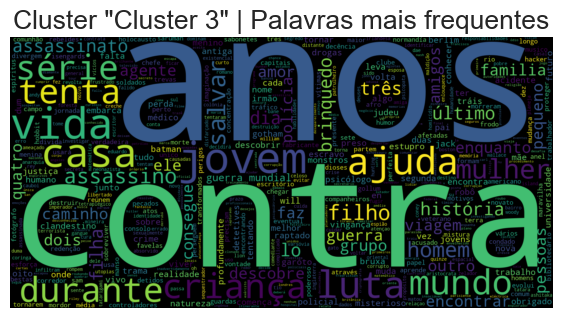

Cluster 0


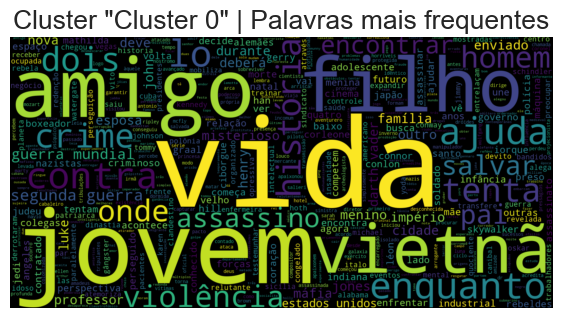

Cluster 1


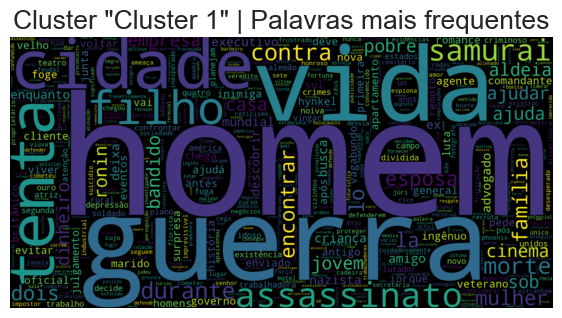

In [152]:
def word_cloud_cluster(cluster:int):
  text = ' '.join([phrase for phrase in df_processed.loc[df_processed.cluster == cluster]['sinopse_no_stopwords']])
  plt.figure(figsize=(7,5), facecolor='None')
  wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Cluster "{cluster}" | Palavras mais frequentes', fontsize = 19)
  plt.show()
  return

list_clusters = df_processed.cluster.unique().tolist()
for c in list_clusters:
  print(c)
  word_cloud_cluster(c)

## Conclusões | Model 2

In [153]:
#Escreva aqui as suas análises / conclusões

# Model #3

## Excluindo a feature "year" dado que o modelo claramente separou os clusters com forte influência do ano de lançamento dos filmes

In [154]:
pd.DataFrame(X.toarray()).shape

(250, 82)

In [155]:
df_processed.shape

(250, 9)

In [156]:
df_all_no_year = pd.concat([
                    df_processed.drop(['cluster','year'], axis = 1),
                    pd.DataFrame(X.toarray())
                   ]
                   , axis = 1
                   )
df_all_no_year

title_pt                     title_en  rating     genre                                            sinopse  word_count                               sinopse_no_stopwords    0    1    2    3    4    5         6    7    8    9   10        11   12   13   14   15   16   17        18        19   20   21   22        23   24       25   26        27   28   29   30        31        32   33   34        35   36   37        38   39   40   41   42        43   44        45   46   47        48        49   50   51   52   53   54   55   56   57   58        59   60   61   62   63        64   65   66   67   68   69   70        71        72   73   74   75        76   77   78   79   80        81
0                            Barbie                       Barbie     7.4  Aventura  viver na terra da barbie é ser um ser perfeito...          29  viver terra barbie perfeito lugar perfeito. me...  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.000000  0.0  0.00000  0.0  0.000000  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.707107  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.707107
1             Um Sonho de Liberdade  1. The Shawshank Redemption     9.3     Drama  dois homens presos se reúnem ao longo de vário...          21  dois homens presos reúnem longo vários anos, e...  0.0  0.0  0.0  0.0  0.0  0.0  0.499298  0.0  0.0  0.0  0.0  0.674508  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.000000  0.0  0.54382  0.0  0.000000  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000
2                 O Poderoso Chefão             2. The Godfather     9.2  Policial  o patriarca idoso de uma dinastia do crime org...          20  patriarca idoso dinastia crime organizado tran...  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.737751  0.000000  0.0  0.0  0.0  0.000000  0.0  0.00000  0.0  0.000000  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.675072  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000
3    Batman: O Cavaleiro das Trevas           3. The Dark Knight     9.0      Ação  quando a ameaça conhecida como o coringa surge...          33  ameaça conhecida coringa surge passado, causa ...  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.707107  0.0  0.00000  0.0  0.000000  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.707107  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000
4              O Poderoso Chefão II     4. The Godfather Part II     9.0  Policial  em 1950, michael corleone, agora à frente da f...          41  1950, michael corleone, agora frente família, ...  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.384293  0.000000  0.0  0.0  0.0  0.000000  0.0  0.00000  0.0  0.000000  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.384293  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.358

## Setup

In [157]:
s = setup(data = df_all_no_year,
          session_id = 123)

## Create Model

In [158]:
mdl_kmeans_all_no_year = create_model('kmeans')

## Assign Model

In [159]:
df_kmeans_all_no_year = assign_model(mdl_kmeans_all_no_year)
display(df_kmeans_all_no_year.Cluster.value_counts())
df_kmeans_all_no_year

Cluster
Cluster 3    86
Cluster 1    66
Cluster 0    59
Cluster 2    39
Name: count, dtype: int64

title_pt                     title_en  rating     genre                                            sinopse  word_count                               sinopse_no_stopwords    0    1    2    3    4    5         6    7    8    9   10        11   12   13   14   15   16   17        18        19   20   21   22        23   24       25   26        27   28   29   30        31        32   33   34        35   36   37        38   39   40   41   42        43   44        45   46   47        48        49   50   51   52   53   54   55   56   57   58        59   60   61   62   63        64   65   66   67   68   69   70        71        72   73   74   75        76   77   78   79   80        81    Cluster
0                            Barbie                       Barbie     7.4  Aventura  viver na terra da barbie é ser um ser perfeito...          29  viver terra barbie perfeito lugar perfeito. me...  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.000000  0.0  0.00000  0.0  0.000000  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.707107  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.707107  Cluster 0
1             Um Sonho de Liberdade  1. The Shawshank Redemption     9.3     Drama  dois homens presos se reúnem ao longo de vário...          21  dois homens presos reúnem longo vários anos, e...  0.0  0.0  0.0  0.0  0.0  0.0  0.499298  0.0  0.0  0.0  0.0  0.674508  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.000000  0.0  0.54382  0.0  0.000000  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  Cluster 3
2                 O Poderoso Chefão             2. The Godfather     9.2  Policial  o patriarca idoso de uma dinastia do crime org...          20  patriarca idoso dinastia crime organizado tran...  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.737751  0.000000  0.0  0.0  0.0  0.000000  0.0  0.00000  0.0  0.000000  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.675072  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  Cluster 3
3    Batman: O Cavaleiro das Trevas           3. The Dark Knight     9.0      Ação  quando a ameaça conhecida como o coringa surge...          33  ameaça conhecida coringa surge passado, causa ...  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.707107  0.0  0.00000  0.0  0.000000  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.707107  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  Cluster 2
4              O Poderoso Chefão II     4. The Godfather Part II     9.0  Policial  em 1950, michael corleone, agora à frente da f...          41  1950, michael corleone, agora frente família, ...  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.384293  0.000000  0.0  0.0  0.0  0.000000  0.0  0.00000  0.0  0.000000  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  

## Analyze Model

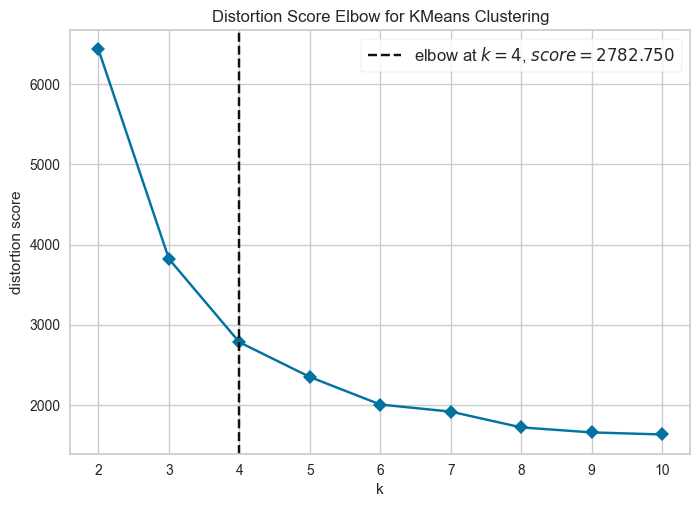

In [160]:
plot_model(mdl_kmeans_all_no_year, plot = 'elbow')

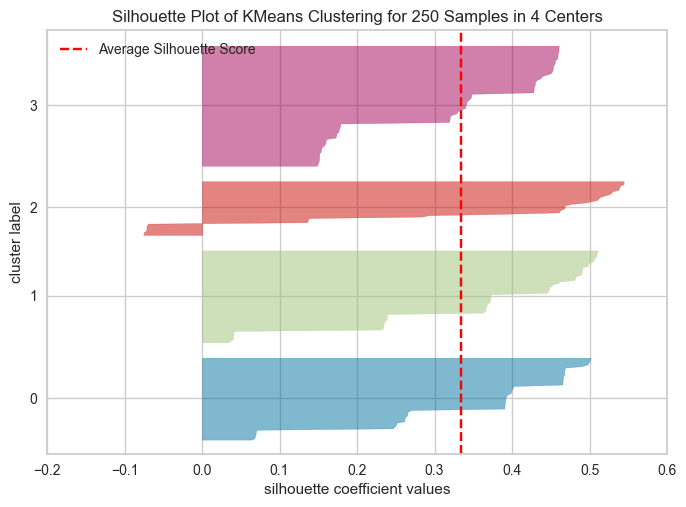

In [161]:
plot_model(mdl_kmeans_all_no_year, plot = 'silhouette')

In [162]:
plot_model(mdl_kmeans_all_no_year, plot = 'distribution')

In [163]:
plot_model(mdl_kmeans_all_no_year, plot = 'cluster')

In [164]:
plot_model(mdl_kmeans_all_no_year, plot = 'tsne')

In [165]:
evaluate_model(mdl_kmeans_all_no_year)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## Filmes por cluster

In [166]:
df_processed['cluster'] = df_kmeans_all_no_year['Cluster']
df_processed

title_pt                     title_en  year  rating     genre                                            sinopse  word_count                               sinopse_no_stopwords    cluster
0                            Barbie                       Barbie  2023     7.4  Aventura  viver na terra da barbie é ser um ser perfeito...          29  viver terra barbie perfeito lugar perfeito. me...  Cluster 0
1             Um Sonho de Liberdade  1. The Shawshank Redemption  1994     9.3     Drama  dois homens presos se reúnem ao longo de vário...          21  dois homens presos reúnem longo vários anos, e...  Cluster 3
2                 O Poderoso Chefão             2. The Godfather  1972     9.2  Policial  o patriarca idoso de uma dinastia do crime org...          20  patriarca idoso dinastia crime organizado tran...  Cluster 3
3    Batman: O Cavaleiro das Trevas           3. The Dark Knight  2008     9.0      Ação  quando a ameaça conhecida como o coringa surge...          33  ameaça conhecida coringa surge passado, causa ...  Cluster 2
4              O Poderoso Chefão II     4. The Godfather Part II  1974     9.0  Policial  em 1950, michael corleone, agora à frente da f...          41  1950, michael corleone, agora frente família, ...  Cluster 2
..                              ...                          ...   ...     ...       ...                                                ...         ...                                                ...        ...
245              Histórias Cruzadas                246. The Help  2011     8.1     Drama  uma aspirante a escritora durante o movimento ...          32  aspirante escritora durante movimento direitos...  Cluster 2
246      Quando Duas Mulheres Pecam                 247. Persona  1966     8.1     Drama  uma enfermeira é encarregada de uma atriz sile...          17  enfermeira encarregada atriz silenciosa descob...  Cluster 1
247                 A Vida de Brian           248. Life of Brian  1979     8.0   Comédia  nascido no natal original no estábulo ao lado ...          20  nascido natal original estábulo lado jesus, br...  Cluster 3
248                         Aladdin                 249. Aladdin  1992     8.0  Animação  um menino de rua bondoso e um vizir competem p...          23  menino rua bondoso vizir competem lâmpada mági...  Cluster 3
249                   As Diabólicas              250. Diabolique  1955     8.1  Policial  a esposa e a amante de um diretor de escola de...          22  esposa amante diretor escola detestável planej...  Cluster 3

[250 rows x 9 columns]

## % de Gêneros por Cluster

In [167]:
fig = px.bar(df_processed.cluster.value_counts(),
             text_auto = True,
             title = 'Qtd de Filmes por Cluster',
             labels = {'index': 'Cluster #',
                       'value':'Qtd. de Filmes'})
fig.show()

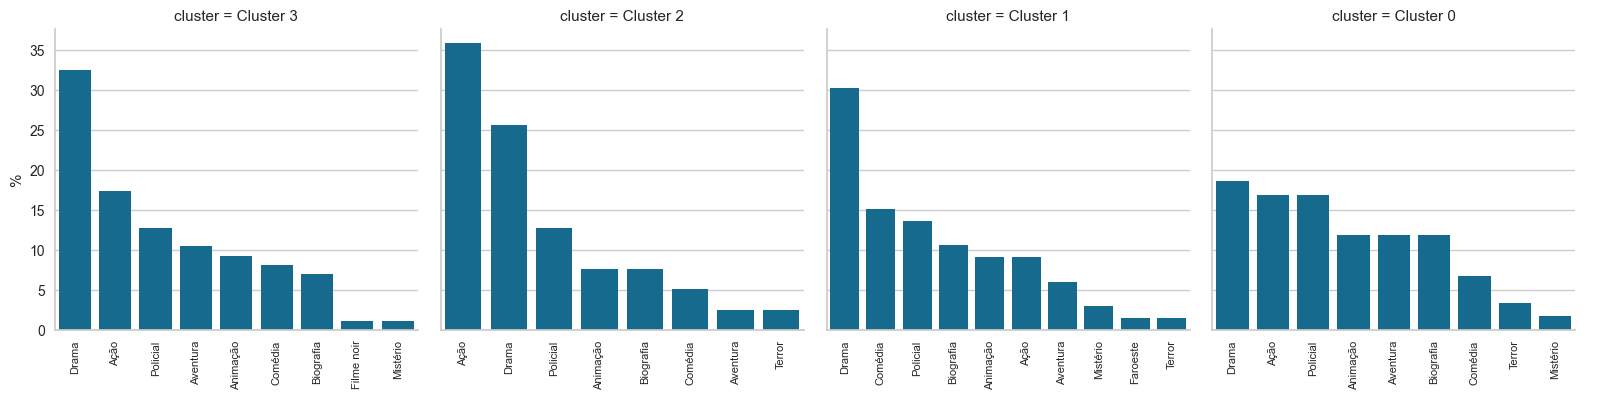

In [168]:
df_plot = df_processed.groupby(['cluster', 'genre'])['title_pt'].count()
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'title_pt':'count'}, inplace = True)
df_plot['%'] = 100 * df_plot['count'] / df_plot.groupby('cluster')['count'].transform('sum')
df_plot = df_plot.sort_values(['cluster', '%'], ascending = False).groupby('cluster').head(11)

fig = sns.catplot(
    data=df_plot, x="genre", y = "%", col="cluster",
    kind="bar", height=4, aspect=1, sharex = False);
fig.set_xlabels('');
fig.set_xticklabels(rotation=90, size = 8);

## Ano de Lançamento por Cluster

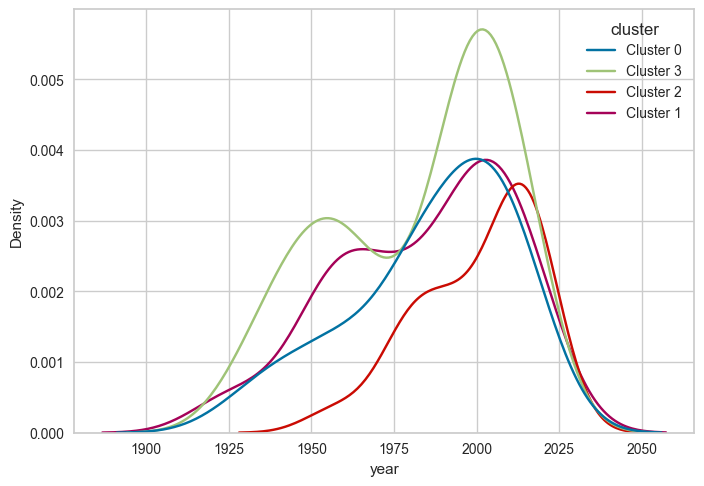

In [169]:
sns.kdeplot(df_processed, x = 'year', hue = 'cluster');

## Radar | Gêneros por Cluster

In [170]:
df_pivot = df_plot.copy()
df_pivot = df_pivot.pivot(index = 'cluster', columns = 'genre', values = '%')
df_pivot.fillna(0, inplace = True)
df_pivot = df_pivot.T.reset_index()
df_pivot.index.name = None
df_pivot

cluster       genre  Cluster 0  Cluster 1  Cluster 2  Cluster 3
0          Animação  11.864407   9.090909   7.692308   9.302326
1          Aventura  11.864407   6.060606   2.564103  10.465116
2              Ação  16.949153   9.090909  35.897436  17.441860
3         Biografia  11.864407  10.606061   7.692308   6.976744
4           Comédia   6.779661  15.151515   5.128205   8.139535
5             Drama  18.644068  30.303030  25.641026  32.558140
6          Faroeste   0.000000   1.515152   0.000000   0.000000
7        Filme noir   0.000000   0.000000   0.000000   1.162791
8          Mistério   1.694915   3.030303   0.000000   1.162791
9          Policial  16.949153  13.636364  12.820513  12.790698
10           Terror   3.389831   1.515152   2.564103   0.000000

In [171]:
df_polar = df_pivot.melt(id_vars=['genre'])
df_polar.head()

genre    cluster      value
0   Animação  Cluster 0  11.864407
1   Aventura  Cluster 0  11.864407
2       Ação  Cluster 0  16.949153
3  Biografia  Cluster 0  11.864407
4    Comédia  Cluster 0   6.779661

In [172]:
fig = px.line_polar(df_polar, r='value', theta='genre', color = 'cluster', line_close=True)
fig.show();

## Nuvem de Palavras por Cluster

## Considerações Finais
* **Exercício: Reescrever as análises / conclusões devido a atualização da base**

Cluster 0


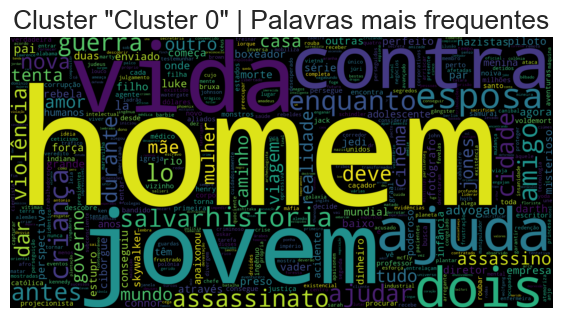

Cluster 3


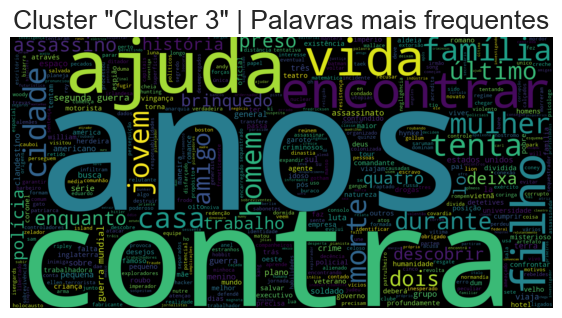

Cluster 2


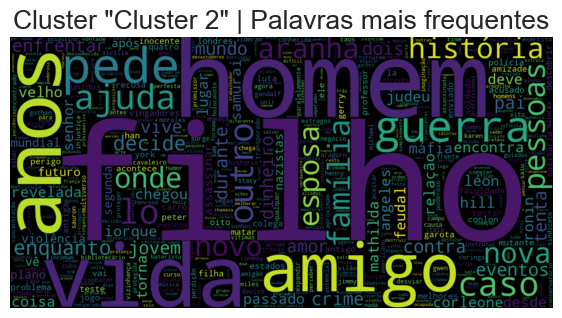

Cluster 1


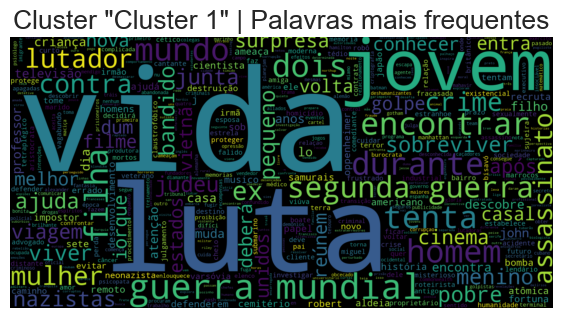

In [173]:
def word_cloud_cluster(cluster:int):
  text = ' '.join([phrase for phrase in df_processed.loc[df_processed.cluster == cluster]['sinopse_no_stopwords']])
  plt.figure(figsize=(7,5), facecolor='None')
  wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Cluster "{cluster}" | Palavras mais frequentes', fontsize = 19)
  plt.show()
  return

list_clusters = df_processed.cluster.unique().tolist()
for c in list_clusters:
  print(c)
  word_cloud_cluster(c)

## Conclusões | Model 3

In [174]:
#Escreva aqui as suas análises / conclusões